In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'numba'

## Thermal model

In [2]:
# Parameters
#   0: resistor R 
#   1: capacitor C
#   2: log_f

@jit
def thermal_model(house_temperature, out_temperature, R, C, temperature_noise=0.0):
    house_temperature = house_temperature + 300 * (out_temperature - house_temperature) / (R * C)
    
    if temperature_noise > 0.0:
        house_temperature += (temperature_noise ** 0.5) * np.random.randn()
        
    return house_temperature
    
@jit
def simulate(theta, out_temperature, temperature_noise=0.0, obs_noise=0.1):
    R, C, log_f = theta
    
    house_temperature = np.zeros(len(out_temperature)+1)
    house_temperature[0] = out_temperature[0]
    
    for i, out in enumerate(out_temperature):
        house_temperature[i+1] = thermal_model(house_temperature[i], out, R, C, temperature_noise=temperature_noise) 
    
    # Observation model:
    # house temperature + N(0.25, noise_var)
    obs_noise = np.exp(log_f) * obs_noise
    obs_temperature = house_temperature + 0.25+(obs_noise ** 0.5) * np.random.randn(*house_temperature.shape)
        
    return house_temperature[1:], obs_temperature[1:]

## Simulate data

In [3]:
from data import load_data_toy

df = load_data_toy()
df.describe()

,house_temperature,outside_temperature
count,102219.000000,102219.000000
mean,19.562064,11.179878
std,2.705468,7.451604
min,14.714286,-9.000000
25%,17.500000,6.000000
50%,18.571429,11.000000
75%,21.785714,16.000000
max,29.171429,34.000000


In [4]:
true_parameters = (135., 200., 0.0)

out_temperature = df["outside_temperature"]
house_temperature, obs_temperature = simulate(true_parameters, out_temperature)

data = np.stack([out_temperature, house_temperature, obs_temperature], axis=1)
train_data = data[:10000, :]
test_data = data[15000:15500, :]

In [5]:
def plot_ts(out_temperature=None,
            house_temperature=None,
            obs_temperature=None):
    if out_temperature is not None:
        plt.plot(out_temperature, label="Outside", color="k", alpha=0.25)

    if house_temperature is not None:
        plt.plot(house_temperature, label="House (groundtruth)", color="r")
        
    if obs_temperature is not None:
        plt.plot(obs_temperature, "b.", label="House (measures)", alpha=0.1)    
       
    plt.legend()
    plt.show()

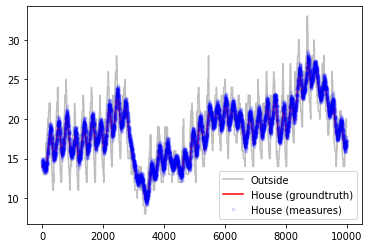

In [6]:
plot_ts(out_temperature=train_data[:, 0],
        house_temperature=train_data[:, 1],
        obs_temperature=train_data[:, 2])

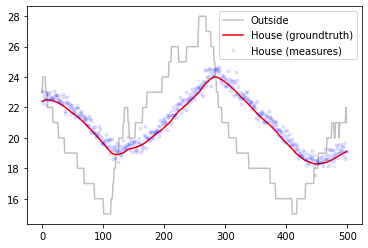

In [7]:
plot_ts(out_temperature=test_data[:, 0],
        house_temperature=test_data[:, 1],
        obs_temperature=test_data[:, 2])

## Maximum likelihood estimation

In [8]:
np.random.seed(777)
theta0 = np.array(true_parameters) + 100 * np.random.randn(3)

In [9]:
pred_house, _ = simulate((theta0[0], theta0[1], theta0[2]), 
                         test_data[:, 0])

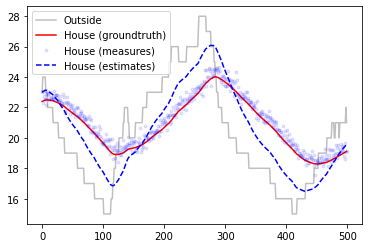

In [10]:
def plot_predictions(out_temperature=None,
                     house_temperature=None,
                     obs_temperature=None,
                     pred_house_temperature=None,
                     pred_obs_temperature=None):
    if out_temperature is not None:
        plt.plot(out_temperature, label="Outside", color="k", alpha=0.25)
        
    if house_temperature is not None:
        plt.plot(house_temperature, label="House (groundtruth)", color="r")
        
    if obs_temperature is not None:
        plt.plot(obs_temperature, "b.", label="House (measures)", alpha=0.1) 
        
    if pred_house_temperature is not None:
        if len(pred_house_temperature.shape) == 1:
            plt.plot(pred_house_temperature, "b--", label="House (estimates)")
        else:
            median = np.percentile(pred_house_temperature, 50, axis=0)
            lower = np.percentile(pred_house_temperature, 2.5, axis=0)
            upper = np.percentile(pred_house_temperature, 97.5, axis=0)
            
            plt.plot(median, "b--", label="House (estimates)")
            plt.fill_between(np.arange(len(median)), lower, upper, color="b", alpha=0.25)

    if pred_obs_temperature is not None:
        if len(pred_obs_temperature.shape) == 1:
            plt.plot(pred_obs_temperature, "g--", label="Posterior predictive", color="g")
        else:
            median = np.percentile(pred_obs_temperature, 50, axis=0)
            lower = np.percentile(pred_obs_temperature, 2.5, axis=0)
            upper = np.percentile(pred_obs_temperature, 97.5, axis=0)
            
            plt.plot(median, "g--", label="Posterior predictive")
            plt.fill_between(np.arange(len(median)), lower, upper, color="g", alpha=0.25)
            
    plt.legend()
    plt.show()
    
plot_predictions(out_temperature=test_data[:, 0],
                 house_temperature=test_data[:, 1],
                 obs_temperature=test_data[:, 2],
                 pred_house_temperature=pred_house)

In [11]:
from scipy.stats import norm

def log_likelihood(theta, out_temperature, obs_temperature):
    R, C, log_f = theta
    house_temperature, _ = simulate(theta, out_temperature)   
    noise_var = np.exp(log_f) * 0.1
    return np.sum(norm.logpdf(obs_temperature, loc=house_temperature+0.25, scale=noise_var ** 0.5))

In [12]:
log_likelihood(true_parameters, train_data[:, 0], train_data[:, 2])

-2707.268356557777

In [13]:
from scipy.optimize import minimize
nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, theta0, args=(train_data[:, 0], train_data[:, 2]))
theta_mle = soln.x

print("theta0:")
print("R = {0:.3f}".format(theta0[0]))
print("C = {0:.3f}".format(theta0[1]))
print("log f = {0:.3f}".format(theta0[2]))
print()

print("MLE estimates:")
print("R = {0:.3f}".format(theta_mle[0]))
print("C = {0:.3f}".format(theta_mle[1]))
print("log f = {0:.3f}".format(theta_mle[2]))

theta0:
R = 88.179
C = 117.718
log f = -6.538

MLE estimates:
R = 138.031
C = 195.620
log f = 0.006


In [14]:
true_parameters

(135.0, 200.0, 0.0)

In [15]:
pred_house, _ = simulate((theta_mle[0], theta_mle[1], theta_mle[2]), 
                         test_data[:, 0])

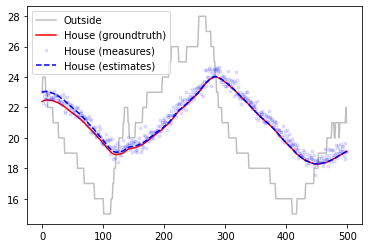

In [16]:
plot_predictions(out_temperature=test_data[:, 0],
                 house_temperature=test_data[:, 1],
                 obs_temperature=test_data[:, 2],
                 pred_house_temperature=pred_house)

## Bayesian Inference

In [17]:
from scipy.stats import norm, uniform

def log_prior(theta):
    R, C, log_f = theta
    return (uniform.logpdf(R, loc=100, scale=150) + 
            uniform.logpdf(C, loc=100, scale=150) + 
            uniform.logpdf(log_f, loc=-2.5, scale=5))

In [18]:
def log_posterior(theta, out_temperature, obs_temperature):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, out_temperature, obs_temperature)

In [19]:
import emcee
from multiprocessing import Pool

pos = theta_mle + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                    args=(train_data[:, 0], train_data[:, 2]), pool=pool)
    sampler.run_mcmc(pos, 10000, progress=True)

100%|██████████| 10000/10000 [03:24<00:00, 48.79it/s]


Text(0.5, 0, 'step number')

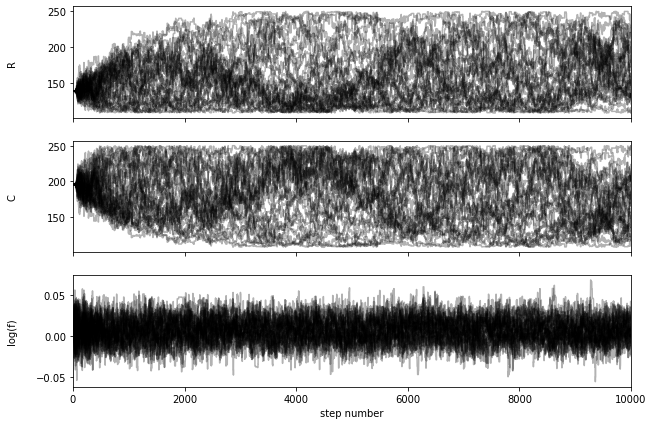

In [20]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["R", "C", "log(f)"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

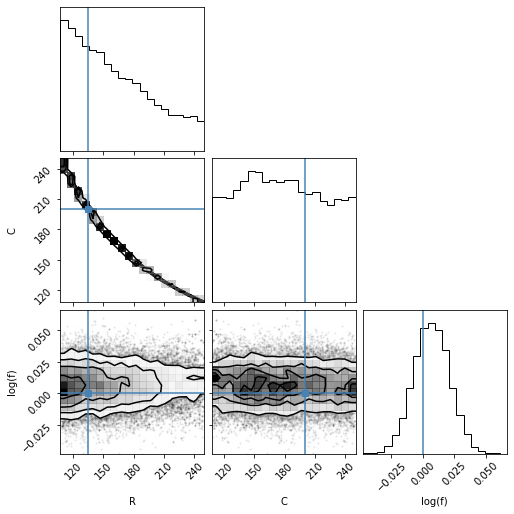

In [21]:
import corner

flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
fig = corner.corner(flat_samples, 
                    labels=labels, 
                    truths=[true_parameters[0], true_parameters[1], true_parameters[2]])

In [22]:
pred_house = []
pred_obs = []

for theta_i in flat_samples:
    pred_house_i, pred_obs_i = simulate((theta_i[0], theta_i[1], theta_i[2]), 
                                        test_data[:, 0])
    pred_house.append(pred_house_i)
    pred_obs.append(pred_obs_i)
    
pred_house = np.array(pred_house)
pred_obs = np.array(pred_obs)

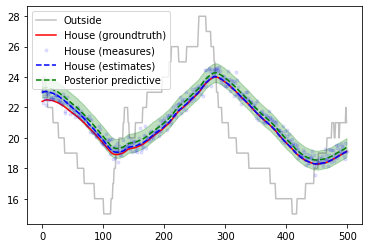

In [23]:
plot_predictions(out_temperature=test_data[:, 0],
                 house_temperature=test_data[:, 1],
                 obs_temperature=test_data[:, 2],
                 pred_house_temperature=pred_house,
                 pred_obs_temperature=pred_obs)